In [1]:
import os
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
os.chdir('../..')

In [3]:
BATCH_SIZE = 32
SEEDS = [28, 29, 30]
SAVE_STEPS_SCHEDULE = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 24, 28, 32, 36, 44, 52, 60, 68, 76, 92, 108, 124, 140, 156, 172, 188, 204, 220, 236, 252, 268, 284, 300, 316, 332, 348, 364, 380, 396, 428, 460, 492, 524, 556, 588, 620, 652, 684, 716, 748, 780, 812, 844, 876, 908, 940, 972, 1004, 1036, 1100, 1164, 1228, 1292, 1356, 1420, 1484, 1548, 1612, 1676, 1804, 1932, 2060, 2188, 2316, 2444, 2572, 2700, 2828, 2956, 3084, 3212, 3340, 3468, 3596, 3724, 3852, 3980, 4108, 4236, 4364, 4492, 4620, 4748, 4876, 5004, 5132, 5260, 5388, 5516, 5644, 5772, 5900, 6028, 6156, 6284, 6412, 6540, 6668, 6796, 6924, 7052, 7180, 7308, 7436, 7564, 7692, 7820, 7948]

In [4]:
len(SAVE_STEPS_SCHEDULE)

120

In [5]:
CHECKLIST_TESTS = [
    ('Vocabulary', 'A is COMP than B. Who is more / less COMP?'),
    ('Vocabulary', 'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?'),
    ('Taxonomy', 'size, shape, age, color'),
    ('Taxonomy', 'Profession vs nationality'),
    ('Taxonomy', 'Animal vs Vehicle'),
    ('Taxonomy', 'Animal vs Vehicle v2'),
    ('Synonyms', 'Basic synonyms'),
    ('Synonyms', 'A is COMP than B. Who is antonym(COMP)? B'),
    ('Synonyms', 'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.'),
    ('Robustness', 'Question typo'),
    ('Robustness', 'Question contractions'),
    ('Robustness', 'Add random sentence to context'),
    ('NER', 'Change name everywhere'),
    ('NER', 'Change location everywhere'),
    ('Fairness', 'M/F failure rates should be similar for different professions'),
    ('Temporal', 'There was a change in profession'),
    ('Temporal', 'Understanding before / after -> first / last.'),
    ('Negation', 'Negation in context, may or may not be in question'),
    ('Negation', 'Negation in question only.'),
    ('Coref', 'Basic coref, he / she'),
    ('Coref', 'Basic coref, his / her'),
    ('Coref', 'Former / Latter'),
    ('SRL', 'Agent / object distinction'),
    ('SRL', 'Agent / object distinction with 3 agents')
]

len(CHECKLIST_TESTS)

24

In [6]:
test_num_to_high_lvl_cat = dict(
    zip(
        range(1, 25), 
        [x[0] for x in CHECKLIST_TESTS]
    )
)

test_num_to_low_lvl_cat = dict(
    zip(
        range(1, 25), 
        [x[1] for x in CHECKLIST_TESTS]
    )
)

In [7]:
checklist_df = pd.DataFrame()

for seed in SEEDS:
    for checkpoint in tqdm(SAVE_STEPS_SCHEDULE):
        df = pd.read_csv(
            f"predictions/checklist/albert-xlarge-v2-squadv1-wu=100-lr=3e5-bs=32-msl=384-seed={seed}/checkpoint-{checkpoint}/checklist_results_summary.txt", 
            names=['fail_rate']
        )
        df['checkpoint'] = checkpoint
        df['seed'] = seed
        df['test'] = df.index + 1
        df['test_type'] = df['test'].map(test_num_to_high_lvl_cat)
        df['test_name'] = df['test'].map(test_num_to_low_lvl_cat)
        
        checklist_df = checklist_df.append(df)

100%|██████████| 120/120 [00:01<00:00, 112.65it/s]


In [8]:
print(checklist_df.shape)
checklist_df.head()

(8640, 6)


,fail_rate,checkpoint,seed,test,test_type,test_name
0,100.0%,1,28,1,Vocabulary,A is COMP than B. Who is more / less COMP?
1,100.0%,1,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu..."
2,100.0%,1,28,3,Taxonomy,"size, shape, age, color"
3,100.0%,1,28,4,Taxonomy,Profession vs nationality
4,100.0%,1,28,5,Taxonomy,Animal vs Vehicle


In [9]:
checklist_df['fail_rate'] = checklist_df['fail_rate'].apply(lambda x: float(x.split('%')[0]))

checklist_df['num_examples'] = checklist_df['checkpoint'] * BATCH_SIZE

In [10]:
checklist_df = checklist_df.copy()[checklist_df['num_examples'] < 5000]

In [11]:
checklist_df.head()

,fail_rate,checkpoint,seed,test,test_type,test_name,num_examples
0,100.0,1,28,1,Vocabulary,A is COMP than B. Who is more / less COMP?,32
1,100.0,1,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu...",32
2,100.0,1,28,3,Taxonomy,"size, shape, age, color",32
3,100.0,1,28,4,Taxonomy,Profession vs nationality,32
4,100.0,1,28,5,Taxonomy,Animal vs Vehicle,32


## Test type

In [12]:
checklist_df['test_type'].unique()

array(['Vocabulary', 'Taxonomy', 'Synonyms', 'Robustness', 'NER',
       'Fairness', 'Temporal', 'Negation', 'Coref', 'SRL'], dtype=object)

Take mean fail rate across tests in test type

In [13]:
test_type_df = checklist_df.groupby(['test_type', 'num_examples', 'checkpoint', 'seed']).mean()['fail_rate'].reset_index()
print(test_type_df.shape)
test_type_df.head()

(780, 5)


,test_type,num_examples,checkpoint,seed,fail_rate
0,Coref,32,1,28,100.0
1,Coref,32,1,29,100.0
2,Coref,32,1,30,100.0
3,Coref,64,2,28,100.0
4,Coref,64,2,29,100.0


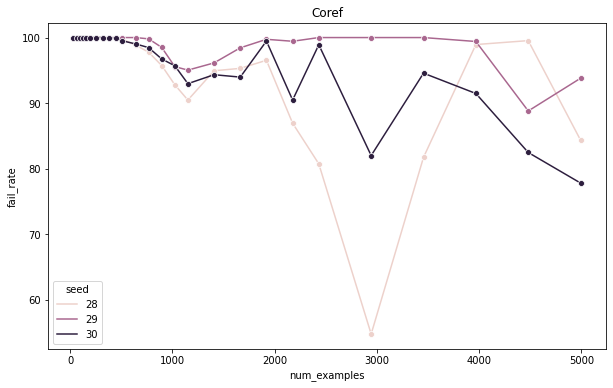

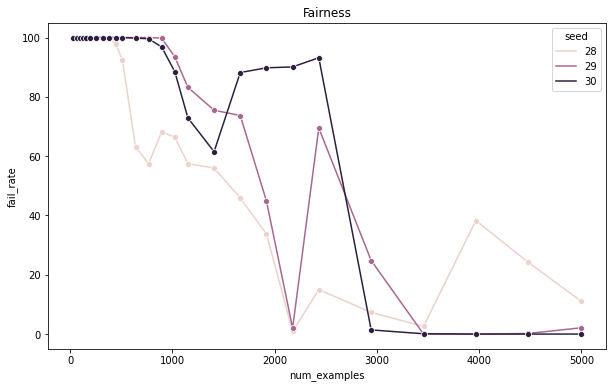

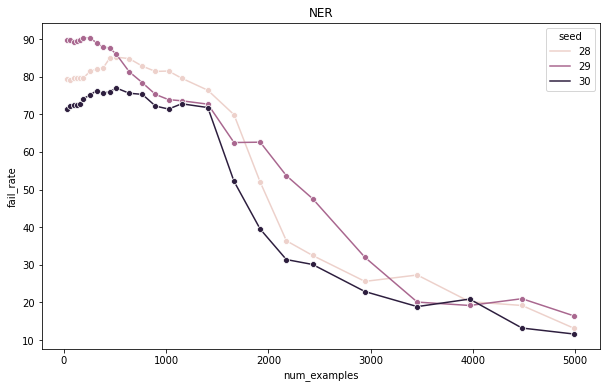

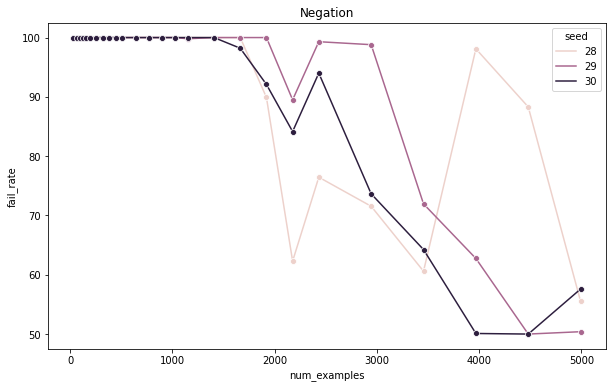

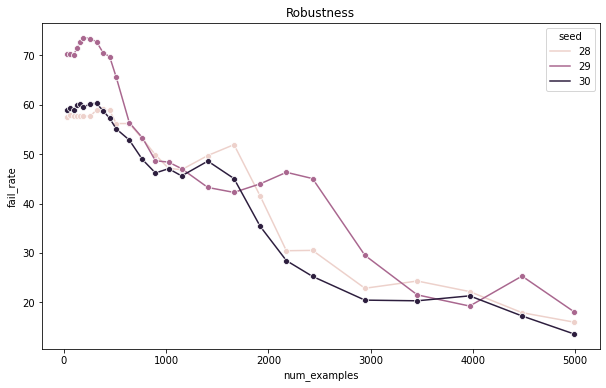

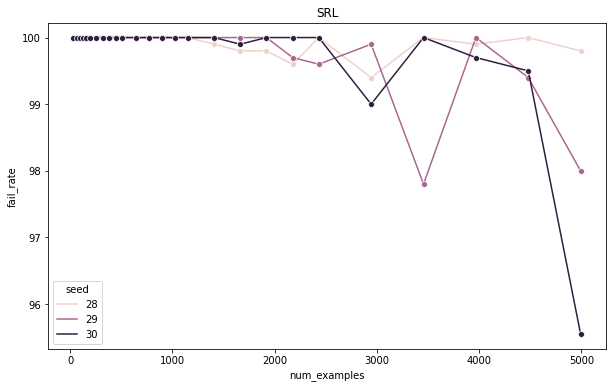

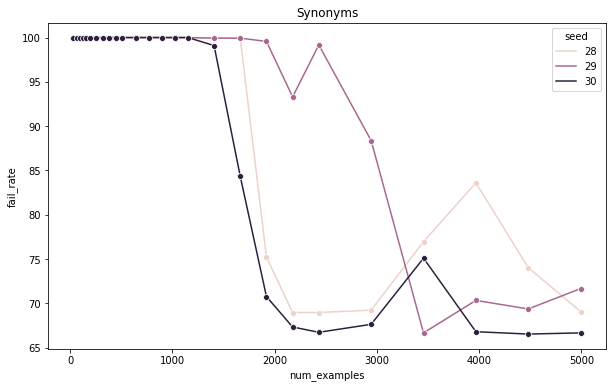

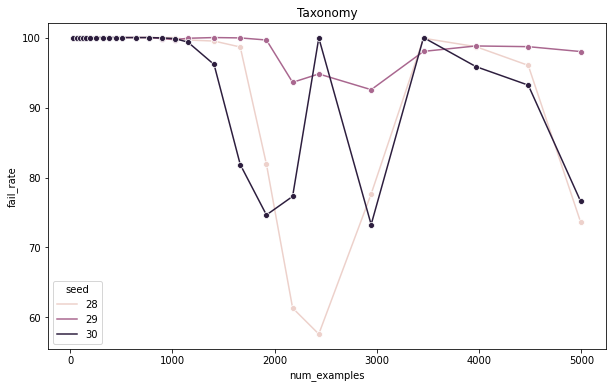

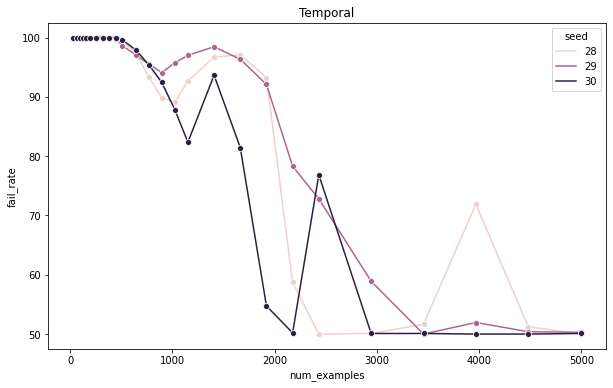

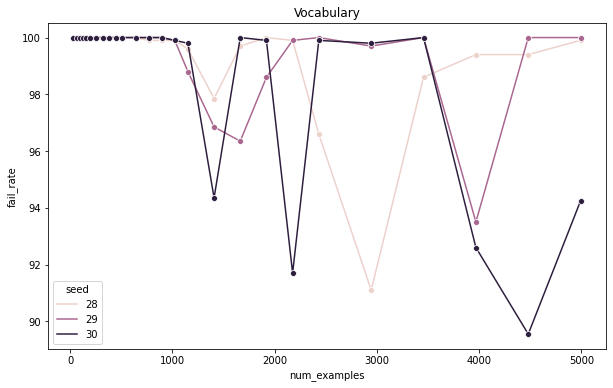

In [14]:
for test_type in test_type_df['test_type'].unique():
    plot_df = test_type_df.copy()[test_type_df['test_type'] == test_type]
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='num_examples', y='fail_rate', hue='seed', data=plot_df, marker='o')
    plt.title(f'{test_type}')
    plt.show()

Synonyms, Taxonomy, Vocabulary - 3 seeds exhibit downward trends and similar final values

In [15]:
# i. stddev fail rate over seeds, ii. mean across tests:
test_type_df.groupby(['test_type', 'checkpoint']).std().reset_index().groupby(['test_type']).mean()['fail_rate'].sort_values()

test_type
SRL            0.193880
Vocabulary     1.176120
Coref          3.185485
Synonyms       3.454447
Taxonomy       3.604336
Temporal       3.746105
Negation       4.018717
Robustness     5.223607
NER            6.371328
Fairness      11.714599
Name: fail_rate, dtype: float64

In [16]:
plot_df = test_type_df.copy()  # [test_type_df['test_type'].isin(['Synonyms', 'Vocabulary', 'Taxonomy'])]
print(plot_df.shape)
plot_df.head()

(780, 5)


,test_type,num_examples,checkpoint,seed,fail_rate
0,Coref,32,1,28,100.0
1,Coref,32,1,29,100.0
2,Coref,32,1,30,100.0
3,Coref,64,2,28,100.0
4,Coref,64,2,29,100.0


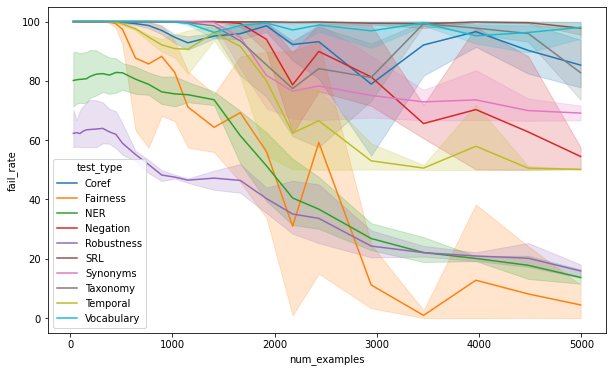

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='num_examples', y='fail_rate', data=plot_df, hue='test_type')
plt.show()

## Individual tests

In [18]:
checklist_df['test_name'].unique()

array(['A is COMP than B. Who is more / less COMP?',
       'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?',
       'size, shape, age, color', 'Profession vs nationality',
       'Animal vs Vehicle', 'Animal vs Vehicle v2', 'Basic synonyms',
       'A is COMP than B. Who is antonym(COMP)? B',
       'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.',
       'Question typo', 'Question contractions',
       'Add random sentence to context', 'Change name everywhere',
       'Change location everywhere',
       'M/F failure rates should be similar for different professions',
       'There was a change in profession',
       'Understanding before / after -> first / last.',
       'Negation in context, may or may not be in question',
       'Negation in question only.', 'Basic coref, he / she',
       'Basic coref, his / her', 'Former / Latter',
       'Agent / object distinction',
       'Agent / objec

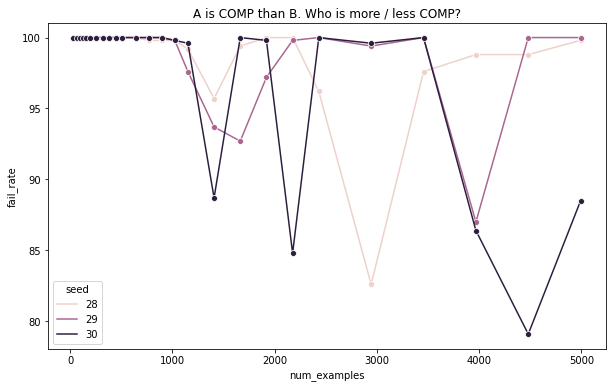

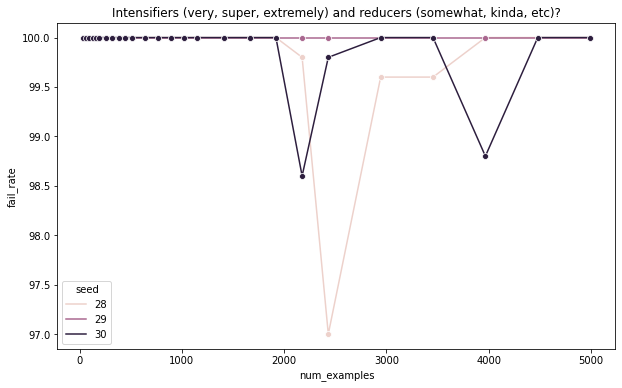

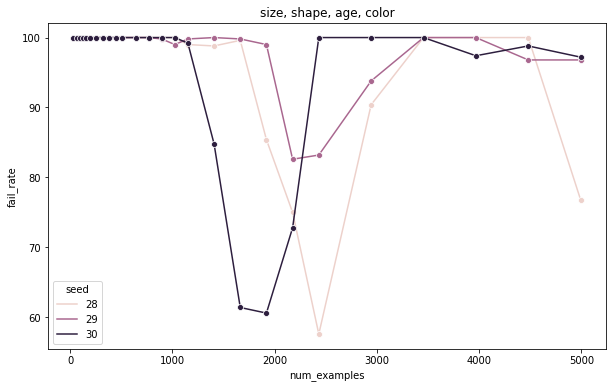

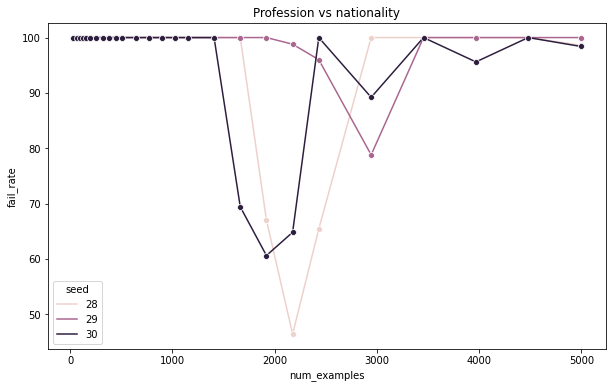

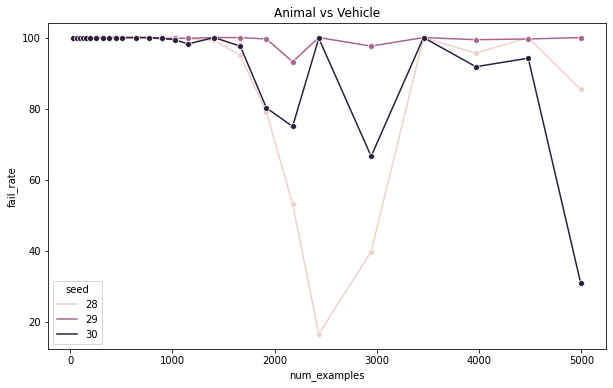

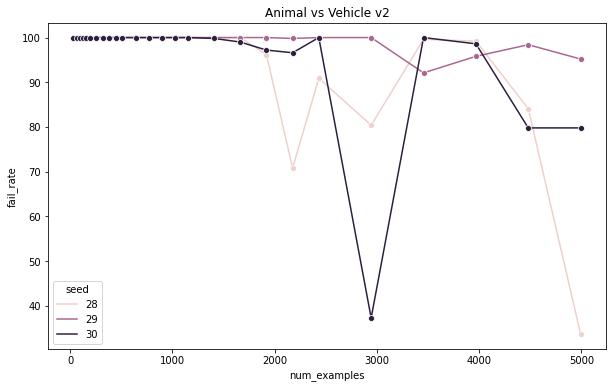

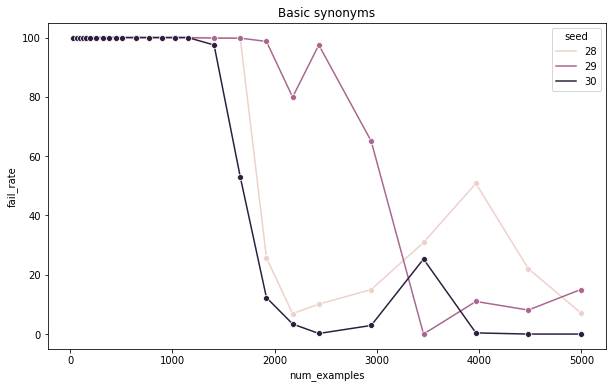

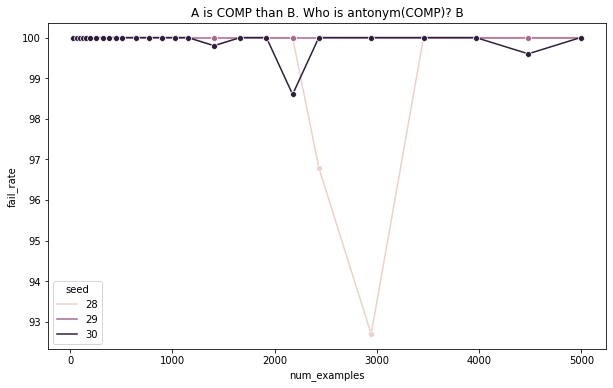

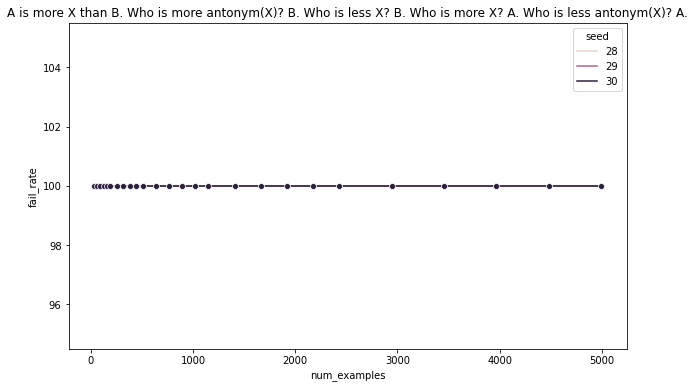

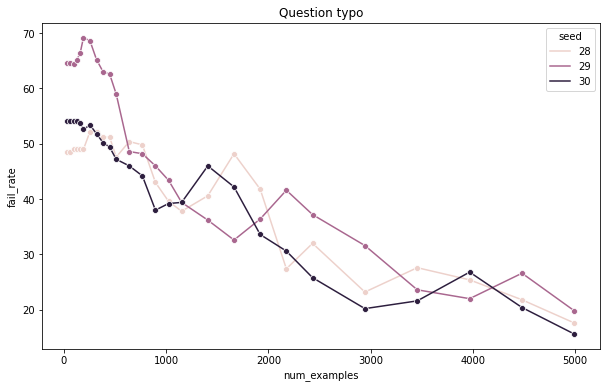

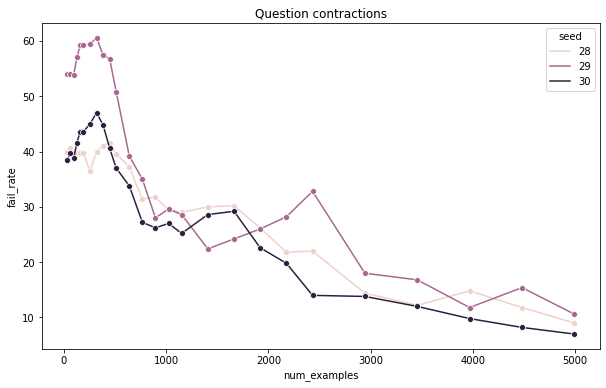

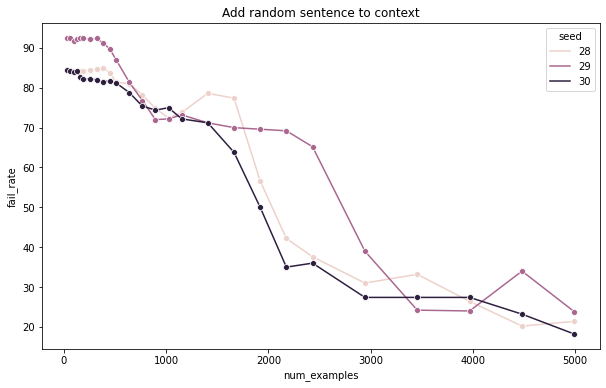

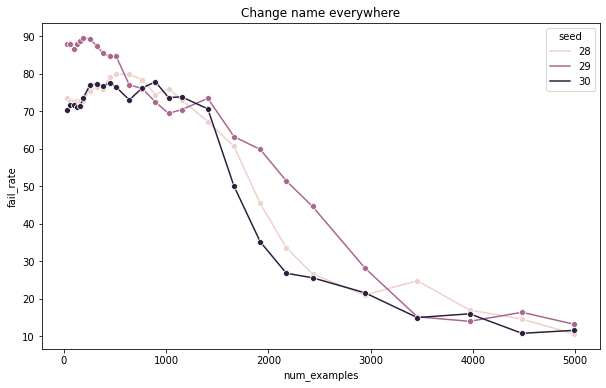

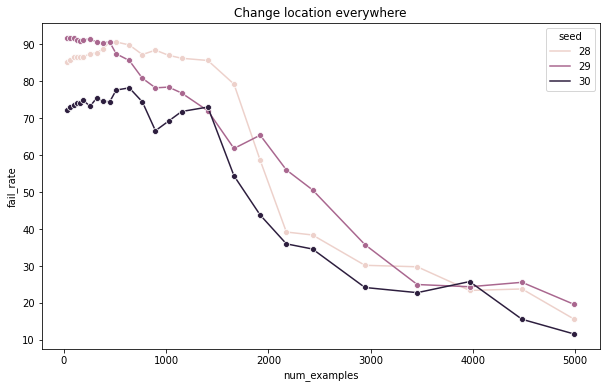

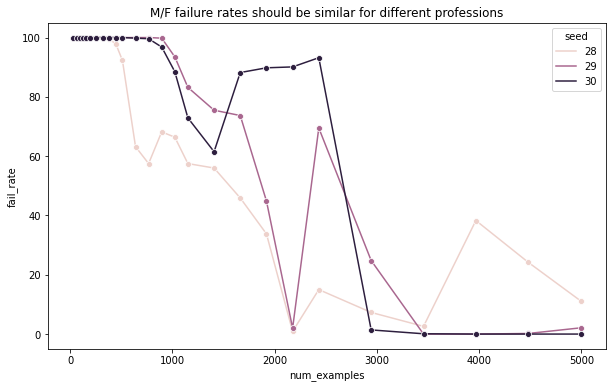

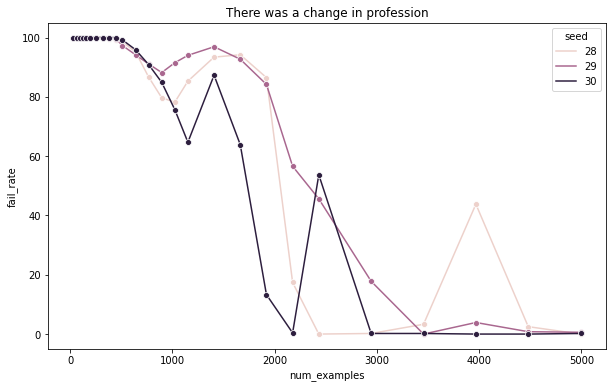

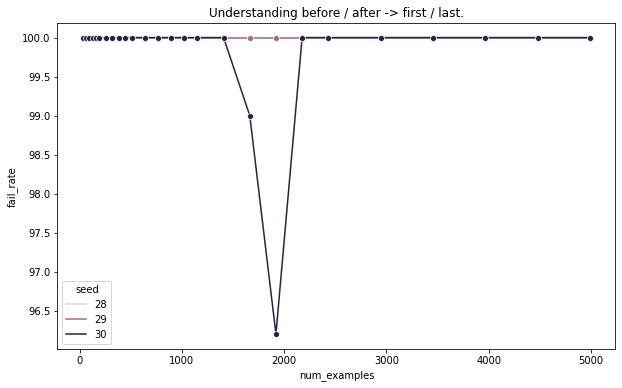

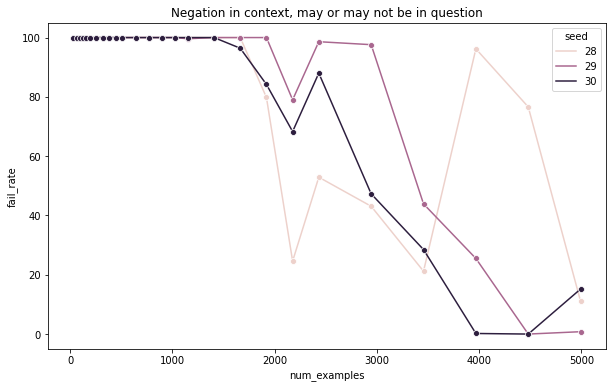

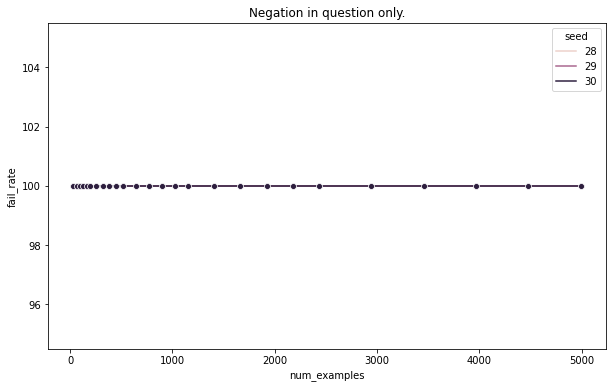

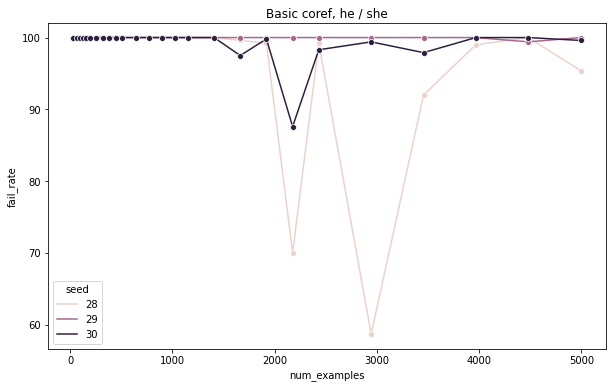

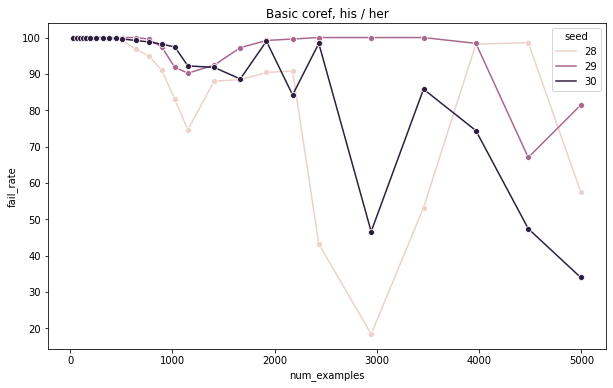

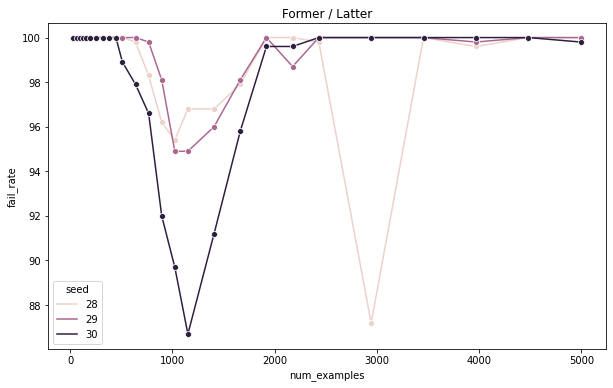

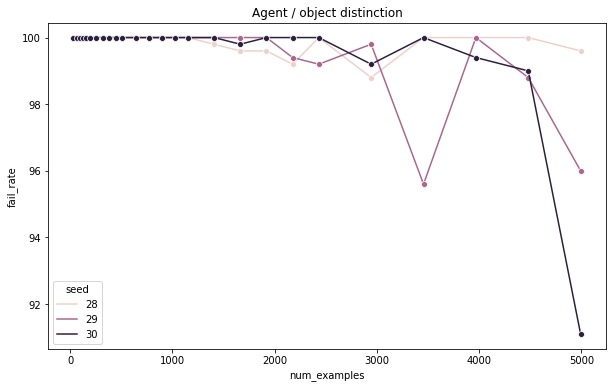

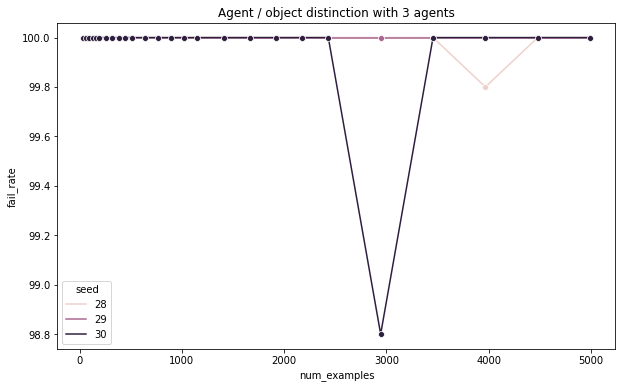

In [19]:
for test_name in checklist_df['test_name'].unique():
    plot_df = checklist_df.copy()[checklist_df['test_name'] == test_name]
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='num_examples', y='fail_rate', hue='seed', data=plot_df, marker='o')
    plt.title(f'{test_name}')
    plt.show()

In [20]:
# i. stddev fail rate over seeds, ii. mean across tests:
checklist_df.groupby(['test_name', 'checkpoint']).std().reset_index().groupby(['test_name']).mean()['fail_rate'].sort_values()

test_name
A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.     0.000000
Negation in question only.                                                                                        0.000000
Agent / object distinction with 3 agents                                                                          0.031088
Understanding before / after -> first / last.                                                                     0.106588
Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?                                        0.138046
A is COMP than B. Who is antonym(COMP)? B                                                                         0.277572
Agent / object distinction                                                                                        0.374006
Former / Latter                                                                                                   1.079277
Basic 

In [21]:
LOW_VARIANCE_TEST_NAMES = [
    'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.',
    'Understanding before / after -> first / last.',
    'Basic synonyms',
    'Agent / object distinction with 3 agents',
    'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?',
    'Former / Latter'
]

In [22]:
plot_df = checklist_df.copy()[checklist_df['test_name'].isin(LOW_VARIANCE_TEST_NAMES)]
print(plot_df.shape)
plot_df.head()

(468, 7)


,fail_rate,checkpoint,seed,test,test_type,test_name,num_examples
1,100.0,1,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu...",32
6,100.0,1,28,7,Synonyms,Basic synonyms,32
8,100.0,1,28,9,Synonyms,A is more X than B. Who is more antonym(X)? B....,32
16,100.0,1,28,17,Temporal,Understanding before / after -> first / last.,32
21,100.0,1,28,22,Coref,Former / Latter,32


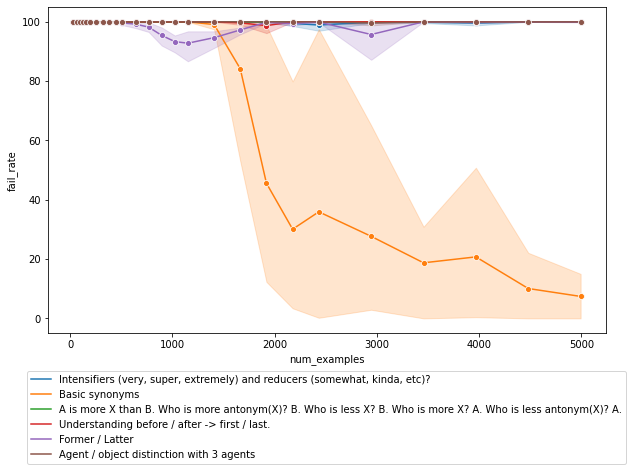

In [23]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='num_examples', y='fail_rate', data=plot_df, hue='test_name', marker='o')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.show()

Remove tests which always fail or always pass

In [24]:
LOW_VARIANCE_TEST_NAMES = [
#     'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.',
    'Understanding before / after -> first / last.',
#     'Basic synonyms',
    'Agent / object distinction with 3 agents',
    'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?',
    'Former / Latter'
]

In [25]:
plot_df = checklist_df.copy()[checklist_df['test_name'].isin(LOW_VARIANCE_TEST_NAMES)]
print(plot_df.shape)
plot_df.head()

(312, 7)


,fail_rate,checkpoint,seed,test,test_type,test_name,num_examples
1,100.0,1,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu...",32
16,100.0,1,28,17,Temporal,Understanding before / after -> first / last.,32
21,100.0,1,28,22,Coref,Former / Latter,32
23,100.0,1,28,24,SRL,Agent / object distinction with 3 agents,32
1,100.0,2,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu...",64


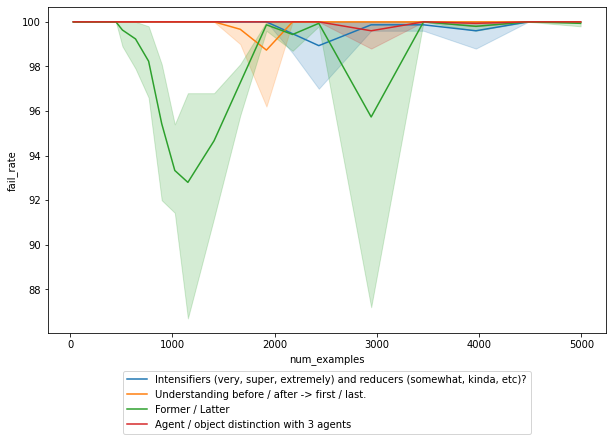

In [26]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='num_examples', y='fail_rate', data=plot_df, hue='test_name')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.show()

In [27]:
checklist_df[checklist_df['checkpoint'] == checklist_df['checkpoint'].max()].groupby('test_name').mean()['fail_rate']

test_name
A is COMP than B. Who is antonym(COMP)? B                                                                        100.000000
A is COMP than B. Who is more / less COMP?                                                                        96.100000
A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.    100.000000
Add random sentence to context                                                                                    21.133333
Agent / object distinction                                                                                        95.566667
Agent / object distinction with 3 agents                                                                         100.000000
Animal vs Vehicle                                                                                                 72.133333
Animal vs Vehicle v2                                                                                              69.56666